In [1]:
%reload_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

from datasets import load_dataset
from urllib.parse import urlparse

In [3]:
os.makedirs("data", exist_ok=True)

In [57]:
import requests
from bs4 import BeautifulSoup


def scrape_website(url, div_classes=None, request_headers={}):
    try:
        response = requests.get(url, headers=request_headers)
        response.raise_for_status()  # Check if the request was successful
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        if not div_classes:  # If no div_classes is provided, return the whole page content
            return soup.get_text(strip=True, separator="\n") 
        
        scraped_text = {}
        for key, val in div_classes.items():
            div_content = soup.find('div', class_=val)
            if div_content:
                scraped_text[key] = div_content.get_text(strip=True, separator="\n")
            else:
                print(f"No div with class '{val}' found for '{key}'.") 
        
        return scraped_text

    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

In [5]:
import random
import time
from tqdm import tqdm


# To avoid 403 Client Error: Forbidden for url
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
]

sleep_times = [1, 2, 3, 4, 5]

# 1. The Onion


## Source 1 (text available)

https://huggingface.co/datasets/Biddls/Onion_News

- The header and body of the news article is split by a ' #~# ' token
- Lines with just the token had no body or no header and can be skipped


In [4]:
onion_ds = load_dataset("Biddls/Onion_News")

In [5]:
onion_df = pd.DataFrame(onion_ds['train'])

In [6]:
onion_df.head()

,text
0,Relaxed Marie Kondo Now Says She Perfectly Hap...
1,U.S. Officials Call For Correct Amount Of Viol...
2,Kamala Harris Asks Communications Assistant If...
3,25 Arrested In Fake Nursing School Diploma Sch...
4,"World’s Oldest American Dies At 72 #~# OXNARD,..."


In [7]:
onion_df.text.values[0][:150]

'Relaxed Marie Kondo Now Says She Perfectly Happy Living In Waist-High Sewage #~# LOS ANGELES—Admitting that she’d made some major lifestyle changes si'

In [8]:
onion_df.text.str.strip().str.match("#~#").sum()

0

In [9]:
onion_df[["headline", "body"]] = onion_df["text"].str.split(" #~# ", expand=True)
onion_df.drop(columns=["text"], inplace=True)

onion_df.head()

,headline,body
0,Relaxed Marie Kondo Now Says She Perfectly Hap...,LOS ANGELES—Admitting that she’d made some maj...
1,U.S. Officials Call For Correct Amount Of Viol...,WASHINGTON—Addressing the need for swift and m...
2,Kamala Harris Asks Communications Assistant If...,WASHINGTON—In an effort to expand her professi...
3,25 Arrested In Fake Nursing School Diploma Scheme,Federal agents have arrested 25 suspects accus...
4,World’s Oldest American Dies At 72,"OXNARD, CA—Living longer than any citizen in t..."


In [10]:
len(onion_df)

33880

In [11]:
onion_df.to_csv("../data/theonion.csv", index=False)

## Source 2 (need to scrape)

https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/data

In [68]:
import json

with open("../data/Sarcasm_Headlines_Dataset.json", "r") as f:
    sarcasm_ds = [json.loads(row) for row in f]

In [84]:
sarcasm_df = pd.DataFrame(sarcasm_ds)

sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [85]:
sarcasm_df = sarcasm_df.query("is_sarcastic == 1").drop(columns=["is_sarcastic"])

len(sarcasm_df)

11724

In [86]:
sarcasm_df = sarcasm_df.rename(columns={"article_link": "url"})

sarcasm_df.head()

,url,headline
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up..."
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...


In [87]:
sarcasm_df.url.values[0]

'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697'

In [88]:
sarcasm_df.url.values[4]

'https://www.theonion.com/cosby-lawyer-asks-why-accusers-didn-t-come-forward-to-b-1819577265'

In [89]:
onion_scrape_test = scrape_website(sarcasm_df.url.values[0], 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow')

print(onion_scrape_test)

Error fetching https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697: HTTPSConnectionPool(host='local.theonion.com', port=443): Max retries exceeded with url: /mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'local.theonion.com'. (_ssl.c:992)")))
None


In [90]:
onion_scrape_test = scrape_website(sarcasm_df.url.values[4], 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow')

print(onion_scrape_test)

LOS ANGELES—Responding to recent allegations that his client sexually assaulted as many as 20 women over the course of his career, an attorney for comedian Bill Cosby asked Wednesday why none of the alleged victims came forward and allowed themselves to be smeared by the entertainer’s powerful attorneys years ago. “One has to wonder why all these claims are being made now, when these women very easily could have spoken up 40 years ago and had my client’s legal team ruin them,” said Cosby lawyer Martin Singer, suggesting that if the assertions were indeed true, the purported victims have had more than ample time to let Cosby’s team of high-priced legal advisors assassinate their character and threaten them with countersuits for defamation. “It’s highly suspect that these women didn’t go public decades ago, when Mr. Cosby could have used his considerable influence to sabotage any chance these women had at a career in show business and obliterate their credibility in media outlets that we

Include only URLs from the main `www.theonion.com` site, exclude any subdomains like `local.theonion.com`, `politics.theonion.com`, etc.

In [91]:
pattern = r'^https://www\.theonion\.com/'
sarcasm_df["is_main"] = sarcasm_df["url"].str.contains(pattern)

sarcasm_df.is_main.value_counts()

is_main
False    5913
True     5811
Name: count, dtype: int64

In [92]:
sarcasm_df = sarcasm_df[sarcasm_df.is_main].drop(columns=["is_main"])

len(sarcasm_df)

5811

In [93]:
sarcasm_df.url.values[0]

'https://www.theonion.com/cosby-lawyer-asks-why-accusers-didn-t-come-forward-to-b-1819577265'

Check if any of these articles are already present in `onion_df`:

In [97]:
onion_headlines = onion_df["headline"].str.lower().str.strip().values

sarcasm_df["headline"].isin(onion_headlines).sum()

3281

Exclude these to avoid duplication:

In [99]:
sarcasm_df = sarcasm_df[~sarcasm_df["headline"].isin(onion_headlines)]

len(sarcasm_df)

2530

Scrape the URLs:

In [102]:
sarcasm_df = sarcasm_df.reset_index(drop=True)

sarcasm_df.index

RangeIndex(start=0, stop=2530, step=1)

In [103]:
onion_div_class = 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow'

sarcasm_df["body"] = None

In [104]:
sleep_times.extend([6, 7])

In [109]:
sarcasm_df.url.values[2]

'https://www.theonion.com/giant-altoid-heading-toward-earth-1819586323'

- NOTE: some of these articles are really old (the one above is from 1997) and the linked article doesn't contain any text.

In [ ]:
for r in tqdm(sarcasm_df.itertuples()):
    if pd.isna(r.body):        
        request_headers = {
            'user-agent': random.choice(user_agents)
        }
        scraped = scrape_website(r.url, {"body": onion_div_class}, request_headers)
        sarcasm_df.at[r.Index, "body"] = scraped["body"]

        time.sleep(random.choice(sleep_times))

0it [00:00, ?it/s]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2it [00:04,  2.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


3it [00:08,  2.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


5it [00:14,  3.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


6it [00:22,  4.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


8it [00:34,  5.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


9it [00:38,  4.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


10it [00:41,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


11it [00:48,  5.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


12it [00:54,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


19it [01:45,  7.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


20it [01:49,  6.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


21it [01:56,  6.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


23it [02:08,  6.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


28it [02:38,  5.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


29it [02:45,  6.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


30it [02:48,  5.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


32it [03:04,  6.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


33it [03:06,  5.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


34it [03:13,  5.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


35it [03:18,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


36it [03:23,  5.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


37it [03:26,  4.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


38it [03:31,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


40it [03:44,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


42it [03:54,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


45it [04:03,  3.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


46it [04:09,  4.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


47it [04:17,  5.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


50it [04:31,  4.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


52it [04:46,  6.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


53it [04:53,  6.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


57it [05:19,  6.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


59it [05:31,  6.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


60it [05:39,  6.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


61it [05:42,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


62it [05:49,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


63it [05:53,  5.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


66it [06:06,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


68it [06:19,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


70it [06:28,  5.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


71it [06:36,  6.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


72it [06:43,  6.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


76it [07:02,  4.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


77it [07:04,  4.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


78it [07:11,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


79it [07:13,  4.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


81it [07:25,  4.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


82it [07:30,  4.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


83it [07:38,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


86it [07:55,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


87it [08:03,  6.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


93it [08:36,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


94it [08:42,  5.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


95it [08:44,  4.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


97it [08:56,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


101it [09:21,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


102it [09:25,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


105it [09:44,  6.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


114it [10:42,  5.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


117it [11:00,  5.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


118it [11:07,  5.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


120it [11:13,  4.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


121it [11:15,  3.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


122it [11:20,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


123it [11:27,  4.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


124it [11:34,  5.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


128it [11:55,  5.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


133it [12:26,  5.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


134it [12:30,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


135it [12:36,  5.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


140it [13:02,  5.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


142it [13:06,  3.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


143it [13:13,  4.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


144it [13:18,  4.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


145it [13:25,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


152it [13:54,  3.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


153it [14:00,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


155it [14:11,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


156it [14:15,  4.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


158it [14:22,  3.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


162it [14:38,  3.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


163it [14:44,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


164it [14:48,  4.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


166it [14:58,  4.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


167it [15:05,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


170it [15:18,  4.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


171it [15:21,  3.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


172it [15:27,  4.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


176it [15:45,  4.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


179it [15:58,  4.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


180it [16:06,  5.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


182it [16:12,  4.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


187it [16:30,  3.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


189it [16:41,  4.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


190it [16:49,  5.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


191it [16:55,  5.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


193it [17:05,  5.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


195it [17:21,  6.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


196it [17:24,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


197it [17:29,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


198it [17:31,  4.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


199it [17:38,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


201it [17:47,  4.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


202it [17:50,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


204it [18:05,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


205it [18:07,  4.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


207it [18:14,  4.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


210it [18:24,  3.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


212it [18:33,  4.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


215it [18:47,  4.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


216it [18:51,  4.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


217it [18:53,  3.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


218it [18:57,  3.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


219it [19:03,  4.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


223it [19:26,  5.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


227it [19:42,  4.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


231it [20:01,  4.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


232it [20:08,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


234it [20:17,  4.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


236it [20:27,  5.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


237it [20:35,  5.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


238it [20:40,  5.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


239it [20:46,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


244it [21:06,  4.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


245it [21:10,  4.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


247it [21:22,  5.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


249it [21:30,  4.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


250it [21:33,  4.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


252it [21:41,  4.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


253it [21:44,  3.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


255it [21:58,  5.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


256it [22:03,  5.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


257it [22:11,  6.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


258it [22:19,  6.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


261it [22:31,  4.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


263it [22:41,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


266it [23:00,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


267it [23:05,  5.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


268it [23:11,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


269it [23:13,  4.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


270it [23:21,  5.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


271it [23:28,  5.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


272it [23:32,  5.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


274it [23:40,  4.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


275it [23:44,  4.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


276it [23:47,  4.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


279it [24:04,  4.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


281it [24:13,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


285it [24:37,  6.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


286it [24:45,  6.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


288it [24:58,  6.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


291it [25:14,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


293it [25:26,  5.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


296it [25:38,  4.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


298it [25:50,  5.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


299it [25:53,  4.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


300it [25:55,  3.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


301it [26:03,  5.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


306it [26:30,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


307it [26:33,  4.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


308it [26:40,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


309it [26:47,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


311it [26:59,  5.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


312it [27:02,  5.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


314it [27:09,  4.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


316it [27:18,  4.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


318it [27:23,  3.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


319it [27:26,  3.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


322it [27:42,  4.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


329it [28:14,  5.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


330it [28:18,  4.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


332it [28:24,  4.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


336it [28:49,  5.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


341it [29:18,  5.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


342it [29:25,  6.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


343it [29:27,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


344it [29:35,  5.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


345it [29:43,  6.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


346it [29:49,  6.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


350it [30:11,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


353it [30:20,  3.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


354it [30:25,  4.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


355it [30:28,  3.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


356it [30:30,  3.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


357it [30:37,  4.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


360it [30:52,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


361it [30:56,  4.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


363it [31:12,  6.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


364it [31:18,  6.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


365it [31:23,  5.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


367it [31:27,  3.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


369it [31:43,  6.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


370it [31:49,  6.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


371it [31:54,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


372it [31:58,  5.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


375it [32:09,  4.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


376it [32:13,  4.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


379it [32:31,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


380it [32:37,  5.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


383it [32:56,  6.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


384it [33:01,  5.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


385it [33:03,  4.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


388it [33:23,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


392it [33:38,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


394it [33:46,  4.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


395it [33:48,  3.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


396it [33:55,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


400it [34:18,  5.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


401it [34:25,  5.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


402it [34:28,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


403it [34:30,  4.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


404it [34:36,  4.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


406it [34:46,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


408it [34:56,  4.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


410it [35:04,  4.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


414it [35:26,  5.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


415it [35:30,  4.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


416it [35:32,  4.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


417it [35:38,  4.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


418it [35:41,  4.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


420it [35:57,  6.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


421it [36:01,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


424it [36:20,  6.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


425it [36:21,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


427it [36:33,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


431it [36:48,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


433it [37:00,  4.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


434it [37:07,  5.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


436it [37:17,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


439it [37:28,  4.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


440it [37:34,  4.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


441it [37:36,  4.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


443it [37:44,  3.87s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


444it [37:50,  4.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


445it [37:54,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


446it [37:57,  3.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


448it [38:04,  3.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


450it [38:12,  3.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


451it [38:19,  4.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


454it [38:29,  3.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


456it [38:36,  3.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


457it [38:41,  4.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


459it [38:51,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


460it [38:57,  5.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


461it [39:04,  5.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


462it [39:07,  4.87s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


465it [39:22,  4.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


467it [39:31,  4.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


470it [39:44,  4.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


474it [40:09,  5.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


475it [40:10,  4.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


476it [40:12,  3.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


478it [40:26,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


483it [40:56,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


484it [40:58,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


485it [41:01,  4.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


487it [41:14,  5.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


488it [41:16,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


489it [41:23,  5.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


490it [41:26,  4.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


495it [41:58,  6.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


496it [42:05,  6.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


497it [42:08,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


499it [42:20,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


500it [42:22,  4.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


503it [42:35,  4.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


504it [42:37,  3.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


506it [42:51,  5.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


507it [42:57,  5.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


508it [43:04,  5.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


510it [43:15,  5.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


512it [43:23,  4.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


513it [43:28,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


514it [43:34,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


516it [43:45,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


520it [44:08,  6.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


522it [44:19,  5.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


523it [44:27,  6.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


525it [44:42,  6.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


528it [44:54,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


529it [44:56,  4.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


530it [45:04,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


532it [45:14,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


534it [45:24,  5.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


535it [45:30,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


536it [45:33,  4.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


537it [45:41,  5.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


538it [45:49,  6.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


539it [45:54,  5.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


542it [46:09,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


543it [46:13,  4.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


544it [46:18,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


546it [46:29,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


549it [46:46,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


552it [46:56,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


553it [47:00,  4.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


556it [47:18,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


557it [47:21,  4.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


559it [47:27,  3.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


560it [47:29,  3.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


562it [47:41,  4.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


564it [47:55,  5.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


565it [47:57,  4.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


566it [48:02,  4.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


568it [48:17,  6.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


569it [48:19,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


572it [48:36,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


575it [48:52,  5.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


577it [49:01,  4.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


579it [49:12,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


581it [49:22,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


582it [49:28,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


590it [50:06,  4.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


591it [50:09,  4.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


592it [50:17,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


595it [50:33,  5.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


596it [50:38,  5.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


597it [50:42,  4.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


598it [50:48,  5.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


600it [50:52,  3.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


603it [51:13,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


604it [51:19,  5.87s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


606it [51:27,  5.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


607it [51:32,  5.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


610it [51:56,  6.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


612it [52:06,  6.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


614it [52:19,  6.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


616it [52:30,  5.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


617it [52:36,  5.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


618it [52:44,  6.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


621it [52:56,  5.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


622it [52:59,  4.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


627it [53:25,  5.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


631it [53:45,  5.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


633it [53:53,  4.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


636it [54:12,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


637it [54:19,  6.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


639it [54:32,  6.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


640it [54:36,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


641it [54:41,  5.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


643it [54:47,  4.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


645it [54:57,  4.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


646it [55:03,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


648it [55:17,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


650it [55:26,  5.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


651it [55:32,  5.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


653it [55:42,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


658it [56:08,  5.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


663it [56:35,  4.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


667it [56:54,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


668it [57:00,  5.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


669it [57:07,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


670it [57:15,  6.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


671it [57:19,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


672it [57:26,  6.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


674it [57:32,  4.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


675it [57:37,  4.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


676it [57:40,  4.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


677it [57:47,  5.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


678it [57:51,  4.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


679it [57:55,  4.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


680it [58:00,  4.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


682it [58:15,  6.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


684it [58:21,  4.43s/it]

Error fetching https://www.theonion.com/the-onion-apologizes-1819574603: 404 Client Error: Not Found for url: https://theonion.com/the-onion-apologizes-1819574603


686it [58:30,  4.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


688it [58:35,  3.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


689it [58:41,  4.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


690it [58:43,  3.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


691it [58:48,  4.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


694it [59:04,  4.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


695it [59:08,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


697it [59:16,  4.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


700it [59:30,  4.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


701it [59:37,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


706it [1:00:05,  5.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


707it [1:00:09,  4.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


708it [1:00:17,  5.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


709it [1:00:22,  5.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


710it [1:00:25,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


711it [1:00:31,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


713it [1:00:40,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


714it [1:00:47,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


716it [1:00:56,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


720it [1:01:07,  3.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


721it [1:01:14,  4.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


723it [1:01:25,  4.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


725it [1:01:31,  3.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


726it [1:01:37,  4.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


727it [1:01:44,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


728it [1:01:50,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


729it [1:01:52,  4.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


730it [1:01:56,  4.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


731it [1:02:01,  4.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


733it [1:02:12,  4.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


734it [1:02:14,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


737it [1:02:35,  6.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


738it [1:02:38,  5.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


739it [1:02:45,  5.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


741it [1:02:49,  3.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


744it [1:03:01,  3.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


745it [1:03:03,  3.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


747it [1:03:15,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


750it [1:03:33,  5.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


758it [1:04:07,  4.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


761it [1:04:19,  4.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


767it [1:04:56,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


769it [1:05:11,  6.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


771it [1:05:18,  5.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


773it [1:05:27,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


779it [1:05:48,  3.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


781it [1:05:58,  4.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


782it [1:06:00,  3.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


785it [1:06:16,  4.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


791it [1:06:50,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


793it [1:06:55,  3.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


794it [1:07:02,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


795it [1:07:05,  4.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


796it [1:07:12,  5.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


798it [1:07:22,  4.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


799it [1:07:29,  5.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


802it [1:07:48,  5.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


803it [1:07:50,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


806it [1:08:04,  5.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


810it [1:08:30,  5.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


811it [1:08:36,  5.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


812it [1:08:40,  5.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


813it [1:08:45,  5.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


814it [1:08:48,  4.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


815it [1:08:51,  4.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


816it [1:08:54,  3.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


817it [1:08:59,  4.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


823it [1:09:26,  4.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


825it [1:09:39,  5.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


827it [1:09:47,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


828it [1:09:53,  4.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


829it [1:09:55,  4.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


831it [1:10:09,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


832it [1:10:16,  5.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


834it [1:10:25,  5.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


836it [1:10:39,  6.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


837it [1:10:43,  5.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


839it [1:10:52,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


841it [1:10:58,  4.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


842it [1:11:03,  4.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


844it [1:11:09,  3.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


845it [1:11:11,  3.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


846it [1:11:17,  3.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


848it [1:11:24,  3.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


850it [1:11:36,  5.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


853it [1:11:45,  3.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


855it [1:12:01,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


858it [1:12:13,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


859it [1:12:17,  4.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


861it [1:12:27,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


862it [1:12:32,  4.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


863it [1:12:39,  5.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


864it [1:12:45,  5.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


865it [1:12:49,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


869it [1:13:11,  4.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


871it [1:13:20,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


872it [1:13:24,  4.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


873it [1:13:30,  4.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


874it [1:13:37,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


875it [1:13:44,  5.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


877it [1:13:54,  5.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


878it [1:13:58,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


879it [1:14:01,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


880it [1:14:07,  4.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


883it [1:14:22,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


885it [1:14:32,  5.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


892it [1:15:03,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


895it [1:15:19,  5.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


896it [1:15:24,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


897it [1:15:30,  5.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


898it [1:15:35,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


901it [1:15:55,  6.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


903it [1:16:02,  4.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


904it [1:16:10,  5.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


905it [1:16:17,  6.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


906it [1:16:22,  5.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


908it [1:16:27,  4.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


911it [1:16:39,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


912it [1:16:47,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


913it [1:16:54,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


914it [1:17:01,  6.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


919it [1:17:32,  6.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


921it [1:17:45,  6.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


922it [1:17:49,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


923it [1:17:54,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


924it [1:18:02,  6.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


925it [1:18:04,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


926it [1:18:10,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


927it [1:18:16,  5.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


928it [1:18:21,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


930it [1:18:32,  5.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


931it [1:18:40,  6.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


932it [1:18:41,  4.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


937it [1:19:08,  5.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


938it [1:19:12,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


939it [1:19:17,  4.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


940it [1:19:19,  4.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


941it [1:19:23,  4.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


942it [1:19:27,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


944it [1:19:41,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


945it [1:19:45,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


947it [1:19:51,  4.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


948it [1:19:55,  4.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


949it [1:20:02,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


950it [1:20:04,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


951it [1:20:07,  3.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


952it [1:20:09,  3.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


953it [1:20:12,  3.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


956it [1:20:25,  4.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


958it [1:20:39,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


962it [1:20:54,  4.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


963it [1:21:01,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


964it [1:21:03,  4.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


966it [1:21:12,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


967it [1:21:16,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


968it [1:21:24,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


969it [1:21:26,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


973it [1:21:50,  5.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


974it [1:21:52,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


977it [1:22:02,  3.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


978it [1:22:05,  3.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


979it [1:22:12,  4.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


984it [1:22:40,  6.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


985it [1:22:42,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


986it [1:22:49,  5.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


987it [1:22:57,  6.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


988it [1:23:04,  6.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


990it [1:23:13,  5.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


991it [1:23:16,  4.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


992it [1:23:24,  5.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


999it [1:23:55,  3.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1000it [1:24:00,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1001it [1:24:06,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1002it [1:24:13,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1004it [1:24:26,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1006it [1:24:32,  4.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1008it [1:24:42,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1009it [1:24:44,  3.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1010it [1:24:50,  4.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1011it [1:24:56,  5.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1013it [1:25:10,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1015it [1:25:24,  6.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1016it [1:25:26,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1018it [1:25:37,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1023it [1:25:58,  4.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1024it [1:26:01,  4.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1025it [1:26:06,  4.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1027it [1:26:14,  4.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1028it [1:26:17,  4.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1032it [1:26:32,  3.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1033it [1:26:39,  4.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1035it [1:26:52,  5.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1039it [1:27:18,  6.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1040it [1:27:24,  6.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1042it [1:27:33,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1043it [1:27:40,  5.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1044it [1:27:46,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1046it [1:27:57,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1052it [1:28:32,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1055it [1:28:47,  4.87s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1056it [1:28:54,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1059it [1:29:08,  5.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1061it [1:29:21,  5.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1062it [1:29:23,  4.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1066it [1:29:46,  5.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1068it [1:29:54,  5.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1070it [1:30:04,  4.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1071it [1:30:06,  3.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1072it [1:30:14,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1076it [1:30:37,  5.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1080it [1:31:03,  6.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1082it [1:31:18,  7.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1083it [1:31:23,  6.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1084it [1:31:31,  7.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1085it [1:31:37,  6.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1086it [1:31:45,  7.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1088it [1:32:00,  7.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1090it [1:32:08,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1093it [1:32:21,  4.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1094it [1:32:23,  3.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1095it [1:32:28,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1098it [1:32:46,  5.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1099it [1:32:52,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1100it [1:32:56,  5.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1102it [1:33:10,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1103it [1:33:12,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1107it [1:33:34,  4.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1112it [1:34:00,  4.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1113it [1:34:05,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1114it [1:34:12,  5.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1115it [1:34:15,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1118it [1:34:30,  4.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1119it [1:34:34,  4.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1120it [1:34:38,  4.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1121it [1:34:44,  4.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1122it [1:34:50,  5.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1123it [1:34:52,  4.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1125it [1:35:05,  5.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1126it [1:35:10,  5.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1127it [1:35:18,  6.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1129it [1:35:31,  6.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1133it [1:35:52,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1134it [1:36:00,  6.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1136it [1:36:10,  5.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1139it [1:36:30,  6.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1141it [1:36:37,  5.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1142it [1:36:41,  4.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1146it [1:36:57,  4.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1147it [1:37:00,  3.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1148it [1:37:05,  4.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1149it [1:37:13,  5.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1150it [1:37:19,  5.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1153it [1:37:33,  4.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1154it [1:37:41,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1155it [1:37:50,  6.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1156it [1:37:54,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1158it [1:38:04,  5.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1159it [1:38:10,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1161it [1:38:20,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1162it [1:38:24,  4.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1164it [1:38:37,  5.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1165it [1:38:45,  6.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1166it [1:38:53,  6.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1167it [1:39:01,  7.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1168it [1:39:04,  5.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1171it [1:39:20,  5.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1174it [1:39:31,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1175it [1:39:37,  4.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1177it [1:39:50,  5.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1180it [1:40:01,  4.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1181it [1:40:06,  4.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1185it [1:40:23,  4.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1186it [1:40:25,  3.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1188it [1:40:35,  4.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1189it [1:40:38,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1190it [1:40:46,  5.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1191it [1:40:51,  5.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1192it [1:40:57,  5.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1193it [1:41:02,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1195it [1:41:13,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1197it [1:41:26,  6.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1198it [1:41:32,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1199it [1:41:35,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1200it [1:41:36,  3.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1205it [1:41:50,  2.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1207it [1:41:58,  3.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1210it [1:42:15,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1212it [1:42:26,  5.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1213it [1:42:28,  4.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1214it [1:42:34,  4.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1215it [1:42:39,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1216it [1:42:45,  5.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1217it [1:42:51,  5.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1218it [1:42:52,  4.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1220it [1:43:04,  4.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1223it [1:43:20,  5.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1224it [1:43:28,  6.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1225it [1:43:34,  6.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1226it [1:43:40,  5.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1227it [1:43:43,  5.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1228it [1:43:52,  6.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1230it [1:44:05,  6.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1231it [1:44:12,  6.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1233it [1:44:21,  5.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1234it [1:44:27,  5.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1235it [1:44:32,  5.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1237it [1:44:48,  6.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1238it [1:44:53,  6.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1239it [1:44:58,  5.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1240it [1:45:05,  6.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1241it [1:45:11,  6.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1242it [1:45:17,  6.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1246it [1:45:44,  6.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1247it [1:45:51,  6.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1248it [1:45:59,  7.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1249it [1:46:03,  5.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1251it [1:46:10,  4.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1252it [1:46:14,  4.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1255it [1:46:28,  4.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1256it [1:46:35,  5.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1257it [1:46:37,  4.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1258it [1:46:44,  5.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1259it [1:46:48,  4.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1260it [1:46:55,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1265it [1:47:20,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1269it [1:47:41,  4.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1270it [1:47:49,  5.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1272it [1:48:00,  5.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1279it [1:48:29,  4.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1280it [1:48:32,  3.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1283it [1:48:47,  5.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1284it [1:48:54,  5.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1286it [1:49:06,  5.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1287it [1:49:11,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1288it [1:49:17,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1289it [1:49:19,  4.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1290it [1:49:27,  5.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1296it [1:50:04,  6.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1297it [1:50:12,  6.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1298it [1:50:17,  6.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1300it [1:50:21,  4.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1302it [1:50:35,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1304it [1:50:47,  6.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1305it [1:50:54,  6.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1307it [1:51:04,  5.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1308it [1:51:06,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1309it [1:51:08,  3.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1310it [1:51:14,  4.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1311it [1:51:16,  3.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1312it [1:51:21,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1316it [1:51:34,  3.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1318it [1:51:43,  4.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1319it [1:51:45,  3.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1321it [1:52:00,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1322it [1:52:05,  5.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1325it [1:52:22,  5.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1330it [1:52:52,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1332it [1:53:02,  5.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1334it [1:53:15,  6.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1335it [1:53:16,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1336it [1:53:18,  3.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1337it [1:53:24,  4.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1338it [1:53:32,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1340it [1:53:42,  5.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1343it [1:54:00,  5.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1345it [1:54:10,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1347it [1:54:21,  5.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1348it [1:54:23,  4.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1349it [1:54:30,  5.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1350it [1:54:37,  5.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1351it [1:54:44,  6.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1352it [1:54:48,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1354it [1:54:56,  4.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1355it [1:55:02,  5.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1357it [1:55:13,  5.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1358it [1:55:15,  4.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1361it [1:55:32,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1362it [1:55:38,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1367it [1:55:58,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1371it [1:56:15,  4.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1374it [1:56:27,  3.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1377it [1:56:43,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1378it [1:56:50,  5.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1379it [1:56:54,  5.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1383it [1:57:08,  3.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1384it [1:57:13,  4.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1391it [1:57:42,  4.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1392it [1:57:49,  4.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1394it [1:58:02,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1399it [1:58:28,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1400it [1:58:36,  6.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1401it [1:58:40,  5.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1402it [1:58:44,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1403it [1:58:50,  5.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1408it [1:59:18,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1410it [1:59:28,  5.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1411it [1:59:34,  5.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1412it [1:59:39,  5.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1413it [1:59:43,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1414it [1:59:51,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1415it [1:59:53,  4.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1417it [2:00:01,  4.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1419it [2:00:08,  3.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1420it [2:00:11,  3.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1421it [2:00:18,  4.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1422it [2:00:26,  5.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1424it [2:00:37,  5.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1425it [2:00:41,  5.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1427it [2:00:49,  4.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1428it [2:00:54,  4.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1430it [2:01:08,  5.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1435it [2:01:39,  5.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1436it [2:01:43,  5.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1437it [2:01:49,  5.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1438it [2:01:57,  6.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1440it [2:02:13,  7.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1442it [2:02:19,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1443it [2:02:26,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1444it [2:02:35,  6.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1445it [2:02:40,  5.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1447it [2:02:50,  5.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1448it [2:02:57,  6.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1449it [2:02:59,  4.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1453it [2:03:20,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1454it [2:03:26,  5.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1455it [2:03:29,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1458it [2:03:42,  4.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1459it [2:03:49,  5.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1461it [2:03:58,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1463it [2:04:11,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1464it [2:04:13,  4.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1465it [2:04:17,  4.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1466it [2:04:23,  4.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1467it [2:04:26,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1468it [2:04:33,  5.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1470it [2:04:44,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1472it [2:04:52,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1473it [2:04:59,  5.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1475it [2:05:06,  4.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1476it [2:05:14,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1478it [2:05:26,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1479it [2:05:34,  6.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1480it [2:05:42,  6.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1481it [2:05:46,  6.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1482it [2:05:50,  5.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1484it [2:06:03,  6.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1485it [2:06:06,  5.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1486it [2:06:11,  5.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1487it [2:06:15,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1489it [2:06:32,  6.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1492it [2:06:50,  6.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1493it [2:06:57,  6.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1494it [2:07:04,  6.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1495it [2:07:07,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1498it [2:07:18,  4.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1499it [2:07:26,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1500it [2:07:33,  6.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1502it [2:07:49,  6.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1504it [2:07:59,  6.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1508it [2:08:20,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1510it [2:08:32,  6.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1511it [2:08:34,  4.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1512it [2:08:36,  3.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1516it [2:09:00,  5.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1517it [2:09:03,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1518it [2:09:07,  4.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1519it [2:09:12,  4.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1521it [2:09:26,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1523it [2:09:32,  4.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1524it [2:09:35,  3.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1525it [2:09:37,  3.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1527it [2:09:47,  4.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1528it [2:09:54,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1529it [2:10:02,  6.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1532it [2:10:22,  6.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1533it [2:10:24,  5.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1534it [2:10:28,  4.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1536it [2:10:42,  6.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1539it [2:10:58,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1541it [2:11:08,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1544it [2:11:26,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1546it [2:11:35,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1547it [2:11:37,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1552it [2:12:07,  5.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1553it [2:12:11,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1557it [2:12:36,  6.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1558it [2:12:42,  6.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1560it [2:12:54,  5.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1563it [2:13:12,  5.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1564it [2:13:18,  5.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1565it [2:13:20,  4.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1566it [2:13:23,  4.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1567it [2:13:25,  3.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1568it [2:13:27,  3.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1569it [2:13:35,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1570it [2:13:37,  3.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1571it [2:13:45,  4.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1572it [2:13:46,  3.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1573it [2:13:52,  4.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1575it [2:14:03,  4.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1576it [2:14:10,  5.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1577it [2:14:12,  4.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1578it [2:14:17,  4.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1579it [2:14:20,  4.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1580it [2:14:24,  4.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1584it [2:14:42,  4.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1587it [2:15:00,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1588it [2:15:05,  5.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1589it [2:15:09,  5.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1590it [2:15:13,  4.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1592it [2:15:20,  4.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1593it [2:15:26,  4.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1594it [2:15:28,  3.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1595it [2:15:30,  3.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1597it [2:15:40,  4.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1599it [2:15:52,  5.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1600it [2:15:55,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1601it [2:16:03,  5.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1602it [2:16:07,  5.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1603it [2:16:11,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1604it [2:16:19,  5.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1605it [2:16:26,  6.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1607it [2:16:32,  4.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1608it [2:16:34,  3.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1609it [2:16:37,  3.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1611it [2:16:52,  5.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1613it [2:17:03,  5.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1615it [2:17:16,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1617it [2:17:23,  4.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1619it [2:17:33,  5.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1620it [2:17:38,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1621it [2:17:43,  4.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1623it [2:17:51,  4.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1624it [2:17:59,  5.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1625it [2:18:04,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1630it [2:18:39,  6.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1633it [2:18:56,  6.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1634it [2:19:03,  6.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1637it [2:19:17,  5.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1638it [2:19:21,  4.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1641it [2:19:38,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1646it [2:19:58,  3.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1648it [2:20:08,  4.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1652it [2:20:26,  4.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1654it [2:20:42,  6.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1656it [2:20:51,  5.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1658it [2:21:02,  5.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1661it [2:21:23,  6.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1663it [2:21:32,  5.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1664it [2:21:40,  6.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1666it [2:21:55,  6.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1671it [2:22:24,  5.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1672it [2:22:32,  6.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1674it [2:22:47,  7.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1675it [2:22:49,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1676it [2:22:53,  5.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1677it [2:22:56,  4.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1678it [2:23:01,  4.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1679it [2:23:09,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1680it [2:23:17,  6.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1682it [2:23:29,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1683it [2:23:34,  5.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1685it [2:23:44,  5.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1687it [2:23:53,  4.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1688it [2:24:01,  5.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1690it [2:24:09,  5.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1691it [2:24:14,  5.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1692it [2:24:16,  4.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1693it [2:24:24,  5.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1694it [2:24:31,  5.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1695it [2:24:33,  4.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1696it [2:24:40,  5.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1697it [2:24:47,  5.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1698it [2:24:53,  5.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1700it [2:25:02,  5.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1701it [2:25:06,  4.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1703it [2:25:19,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1705it [2:25:31,  5.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1709it [2:25:50,  5.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1710it [2:25:57,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1712it [2:26:03,  4.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1713it [2:26:06,  3.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1714it [2:26:13,  4.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1716it [2:26:21,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1717it [2:26:29,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1719it [2:26:42,  6.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1720it [2:26:48,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1721it [2:26:51,  5.14s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1722it [2:26:57,  5.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1723it [2:27:00,  4.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1726it [2:27:17,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1729it [2:27:27,  4.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1730it [2:27:31,  3.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1733it [2:27:40,  3.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1736it [2:27:56,  5.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1737it [2:28:04,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1745it [2:28:45,  5.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1746it [2:28:53,  6.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1751it [2:29:26,  6.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1752it [2:29:35,  7.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1758it [2:30:09,  5.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1759it [2:30:14,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1762it [2:30:26,  4.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1763it [2:30:28,  3.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1764it [2:30:31,  3.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1767it [2:30:47,  4.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1772it [2:31:14,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1774it [2:31:25,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1777it [2:31:36,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1778it [2:31:41,  4.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1779it [2:31:43,  3.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1781it [2:31:52,  4.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1782it [2:31:57,  4.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1783it [2:32:01,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1785it [2:32:11,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1786it [2:32:17,  5.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1787it [2:32:22,  5.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1788it [2:32:28,  5.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1790it [2:32:38,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1792it [2:32:51,  5.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1794it [2:33:00,  5.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1795it [2:33:04,  4.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1798it [2:33:16,  4.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1800it [2:33:25,  4.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1804it [2:33:46,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1805it [2:33:55,  6.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1807it [2:34:06,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1808it [2:34:10,  5.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1810it [2:34:22,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1812it [2:34:31,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1813it [2:34:38,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1815it [2:34:50,  5.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1817it [2:34:54,  4.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1818it [2:35:00,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1820it [2:35:16,  6.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1821it [2:35:24,  6.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1822it [2:35:27,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1825it [2:35:41,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1826it [2:35:44,  4.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1827it [2:35:51,  5.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1828it [2:36:00,  6.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1832it [2:36:25,  5.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1835it [2:36:45,  6.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1836it [2:36:53,  6.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1837it [2:36:55,  5.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1838it [2:36:57,  4.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1842it [2:37:29,  7.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1843it [2:37:32,  5.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1845it [2:37:44,  5.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1847it [2:37:54,  5.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1848it [2:37:59,  5.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1850it [2:38:07,  4.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1851it [2:38:15,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1853it [2:38:25,  5.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1854it [2:38:32,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1856it [2:38:40,  4.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1857it [2:38:47,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1858it [2:38:51,  5.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1859it [2:38:57,  5.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1860it [2:39:02,  5.24s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1862it [2:39:10,  4.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1864it [2:39:16,  3.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1865it [2:39:20,  3.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1866it [2:39:24,  3.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1867it [2:39:29,  4.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1870it [2:39:44,  4.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1871it [2:39:49,  4.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1872it [2:39:53,  4.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1873it [2:39:57,  4.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1877it [2:40:17,  5.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1878it [2:40:21,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1879it [2:40:28,  5.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1880it [2:40:36,  6.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1881it [2:40:41,  5.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1883it [2:40:53,  5.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1887it [2:41:19,  6.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1888it [2:41:24,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1889it [2:41:29,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1890it [2:41:35,  5.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1892it [2:41:44,  4.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1894it [2:41:57,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1896it [2:42:09,  5.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1897it [2:42:17,  6.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1898it [2:42:22,  6.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1900it [2:42:35,  6.38s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1901it [2:42:40,  5.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1904it [2:42:58,  6.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1906it [2:43:12,  6.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1907it [2:43:20,  6.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1909it [2:43:28,  5.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1910it [2:43:32,  5.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1913it [2:43:47,  5.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1916it [2:43:59,  4.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1917it [2:44:06,  5.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1918it [2:44:12,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1919it [2:44:14,  4.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1922it [2:44:33,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1924it [2:44:43,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1926it [2:45:00,  6.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1931it [2:45:22,  4.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1934it [2:45:37,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1936it [2:45:48,  5.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1937it [2:45:52,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1940it [2:46:04,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1941it [2:46:10,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1943it [2:46:21,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1945it [2:46:30,  5.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1947it [2:46:42,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1948it [2:46:49,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1950it [2:47:04,  6.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1951it [2:47:10,  6.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1952it [2:47:14,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1954it [2:47:26,  5.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1956it [2:47:40,  6.51s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1957it [2:47:48,  6.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1959it [2:48:01,  6.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1962it [2:48:22,  7.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1964it [2:48:38,  7.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1967it [2:48:58,  7.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1968it [2:49:03,  6.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1969it [2:49:09,  6.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1970it [2:49:13,  5.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1973it [2:49:29,  5.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1975it [2:49:41,  6.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1978it [2:50:01,  6.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1979it [2:50:04,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1980it [2:50:08,  4.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1981it [2:50:15,  5.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1983it [2:50:20,  4.06s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1984it [2:50:25,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1985it [2:50:27,  3.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1987it [2:50:37,  4.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1988it [2:50:44,  5.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1992it [2:51:05,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1993it [2:51:10,  5.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1994it [2:51:13,  4.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1995it [2:51:17,  4.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


1998it [2:51:32,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2001it [2:51:54,  6.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2003it [2:52:04,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2007it [2:52:24,  4.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2008it [2:52:32,  5.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2010it [2:52:37,  4.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2012it [2:52:44,  3.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2013it [2:52:48,  3.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2014it [2:52:52,  3.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2015it [2:52:56,  3.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2018it [2:53:14,  5.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2019it [2:53:21,  5.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2020it [2:53:29,  6.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2021it [2:53:31,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2024it [2:53:47,  4.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2025it [2:53:54,  5.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2026it [2:53:58,  4.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2027it [2:54:01,  4.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2028it [2:54:09,  5.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2030it [2:54:21,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2032it [2:54:35,  6.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2033it [2:54:40,  5.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2037it [2:55:00,  5.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2041it [2:55:19,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2042it [2:55:23,  4.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2043it [2:55:26,  4.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2044it [2:55:33,  5.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2046it [2:55:44,  5.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2049it [2:55:59,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2053it [2:56:20,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2060it [2:56:46,  4.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2061it [2:56:53,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2064it [2:57:09,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2066it [2:57:18,  4.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2067it [2:57:26,  5.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2068it [2:57:32,  5.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2069it [2:57:38,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2070it [2:57:45,  6.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2071it [2:57:47,  4.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2072it [2:57:52,  5.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2073it [2:57:58,  5.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2074it [2:58:04,  5.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2075it [2:58:12,  6.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2076it [2:58:14,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2078it [2:58:24,  5.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2080it [2:58:39,  6.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2081it [2:58:46,  6.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2082it [2:58:48,  5.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2085it [2:59:05,  5.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2086it [2:59:07,  4.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2088it [2:59:19,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2089it [2:59:24,  5.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2091it [2:59:35,  5.45s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2092it [2:59:37,  4.56s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2093it [2:59:40,  4.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2095it [2:59:53,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2096it [2:59:55,  4.41s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2097it [2:59:58,  3.83s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2099it [3:00:09,  4.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2100it [3:00:16,  5.60s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2101it [3:00:23,  6.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2102it [3:00:31,  6.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2104it [3:00:44,  6.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2105it [3:00:50,  6.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2106it [3:00:56,  6.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2110it [3:01:23,  6.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2111it [3:01:29,  6.42s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2113it [3:01:37,  5.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2115it [3:01:59,  8.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2120it [3:02:27,  6.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2121it [3:02:29,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2126it [3:02:54,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2128it [3:03:06,  5.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2130it [3:03:18,  6.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2131it [3:03:24,  6.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2133it [3:03:40,  6.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2134it [3:03:46,  6.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2136it [3:03:58,  6.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2137it [3:04:01,  5.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2139it [3:04:14,  5.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2142it [3:04:31,  5.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2143it [3:04:39,  6.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2144it [3:04:44,  6.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2145it [3:04:48,  5.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2148it [3:05:04,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2149it [3:05:06,  4.07s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2150it [3:05:13,  4.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2152it [3:05:18,  3.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2158it [3:05:46,  4.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2159it [3:05:51,  4.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2160it [3:05:59,  5.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2161it [3:06:03,  5.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2162it [3:06:10,  5.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2164it [3:06:18,  4.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2165it [3:06:21,  4.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2168it [3:06:41,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2171it [3:07:00,  6.02s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2174it [3:07:13,  4.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2177it [3:07:29,  5.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2184it [3:08:05,  5.46s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2186it [3:08:11,  4.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2189it [3:08:27,  4.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2191it [3:08:36,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2193it [3:08:51,  6.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2197it [3:09:03,  3.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2199it [3:09:17,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2201it [3:09:27,  4.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2202it [3:09:33,  5.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2204it [3:09:40,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2207it [3:09:59,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2209it [3:10:03,  3.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2211it [3:10:12,  4.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2215it [3:10:31,  3.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2216it [3:10:37,  4.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2217it [3:10:44,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2219it [3:10:51,  4.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2220it [3:10:54,  3.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2221it [3:11:00,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2222it [3:11:02,  3.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2224it [3:11:14,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2225it [3:11:21,  5.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2226it [3:11:23,  4.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2231it [3:11:52,  5.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2232it [3:11:54,  4.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2233it [3:11:56,  3.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2234it [3:12:03,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2236it [3:12:13,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2237it [3:12:19,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2239it [3:12:29,  5.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2240it [3:12:37,  5.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2241it [3:12:45,  6.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2242it [3:12:51,  6.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2243it [3:12:54,  5.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2246it [3:13:08,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2247it [3:13:11,  4.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2248it [3:13:15,  4.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2249it [3:13:19,  4.33s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2250it [3:13:21,  3.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2252it [3:13:34,  5.00s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2254it [3:13:44,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2255it [3:13:47,  4.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2256it [3:13:53,  4.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2257it [3:13:55,  4.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2259it [3:14:03,  4.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2260it [3:14:10,  4.96s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2261it [3:14:13,  4.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2265it [3:14:33,  5.04s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2266it [3:14:37,  4.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2267it [3:14:39,  3.98s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2270it [3:14:53,  4.16s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2271it [3:14:59,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2272it [3:15:04,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2273it [3:15:07,  4.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2274it [3:15:12,  4.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2277it [3:15:32,  5.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2278it [3:15:40,  6.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2282it [3:16:03,  6.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2283it [3:16:05,  4.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2286it [3:16:23,  5.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2289it [3:16:32,  3.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2290it [3:16:38,  4.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2291it [3:16:40,  3.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2295it [3:16:56,  3.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2296it [3:17:02,  4.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2297it [3:17:04,  3.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2299it [3:17:10,  3.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2300it [3:17:18,  4.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2302it [3:17:25,  4.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2304it [3:17:34,  4.54s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2305it [3:17:39,  4.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2308it [3:17:56,  4.89s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2309it [3:18:03,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2311it [3:18:13,  5.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2312it [3:18:17,  4.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2313it [3:18:25,  5.90s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2316it [3:18:41,  5.40s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2318it [3:18:54,  5.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2320it [3:19:05,  5.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2322it [3:19:18,  6.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2324it [3:19:34,  7.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2325it [3:19:40,  6.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2327it [3:19:49,  5.84s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2329it [3:20:00,  5.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2330it [3:20:07,  6.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2332it [3:20:22,  6.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2333it [3:20:27,  6.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2335it [3:20:38,  5.93s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2337it [3:20:51,  6.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2338it [3:20:53,  5.03s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2339it [3:20:55,  4.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2340it [3:21:01,  4.79s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2341it [3:21:08,  5.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2342it [3:21:10,  4.34s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2345it [3:21:21,  4.37s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2346it [3:21:30,  5.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2349it [3:21:43,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2350it [3:21:50,  5.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2351it [3:21:54,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2353it [3:22:07,  5.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2357it [3:22:25,  4.50s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2359it [3:22:40,  5.92s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2361it [3:22:52,  6.20s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2362it [3:22:55,  5.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2364it [3:23:07,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2365it [3:23:13,  5.70s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2366it [3:23:15,  4.59s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2367it [3:23:18,  3.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2368it [3:23:25,  4.85s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2369it [3:23:29,  4.67s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2370it [3:23:37,  5.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2371it [3:23:43,  5.87s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2372it [3:23:50,  5.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2374it [3:23:57,  4.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2377it [3:24:15,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2378it [3:24:18,  4.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2380it [3:24:26,  4.39s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2381it [3:24:32,  4.62s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2385it [3:24:55,  6.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2387it [3:25:00,  4.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2389it [3:25:10,  4.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2390it [3:25:17,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2391it [3:25:26,  6.29s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2393it [3:25:35,  5.66s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2395it [3:25:47,  5.73s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2397it [3:25:58,  5.68s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2398it [3:26:00,  4.61s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2399it [3:26:05,  4.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2400it [3:26:11,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2402it [3:26:20,  4.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2403it [3:26:27,  5.55s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2405it [3:26:37,  5.17s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2406it [3:26:39,  4.26s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2407it [3:26:45,  4.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2409it [3:26:53,  4.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2410it [3:27:00,  5.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2411it [3:27:04,  4.95s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2412it [3:27:10,  5.25s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2413it [3:27:16,  5.52s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2417it [3:27:40,  5.71s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2420it [3:27:52,  4.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2421it [3:27:55,  4.15s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2422it [3:28:02,  5.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2425it [3:28:14,  4.27s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2426it [3:28:18,  4.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2428it [3:28:30,  5.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2430it [3:28:39,  4.72s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2431it [3:28:42,  4.28s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2433it [3:28:55,  5.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2434it [3:29:01,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2435it [3:29:05,  5.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2436it [3:29:13,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2437it [3:29:17,  5.36s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2438it [3:29:22,  5.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2442it [3:29:47,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2444it [3:29:57,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2445it [3:30:03,  5.77s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2447it [3:30:14,  5.58s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2448it [3:30:18,  5.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2451it [3:30:39,  6.76s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2452it [3:30:44,  6.01s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2454it [3:30:56,  6.31s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2455it [3:31:00,  5.65s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2460it [3:31:37,  7.11s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2462it [3:31:49,  6.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2463it [3:31:58,  6.99s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2465it [3:32:04,  5.10s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2466it [3:32:10,  5.47s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2468it [3:32:17,  4.35s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2469it [3:32:23,  4.91s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2470it [3:32:30,  5.57s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2472it [3:32:42,  5.64s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2474it [3:32:46,  3.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2476it [3:32:57,  4.87s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2477it [3:32:59,  4.05s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2478it [3:33:07,  5.32s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2479it [3:33:15,  6.12s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2480it [3:33:21,  6.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2483it [3:33:42,  6.63s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2484it [3:33:46,  5.94s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2486it [3:33:54,  4.69s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2488it [3:34:04,  4.78s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2489it [3:34:11,  5.23s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2490it [3:34:17,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2492it [3:34:30,  6.13s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2493it [3:34:33,  5.21s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2494it [3:34:40,  5.53s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2496it [3:34:52,  5.82s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2497it [3:35:00,  6.49s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2499it [3:35:13,  6.44s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2500it [3:35:17,  5.75s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2504it [3:35:36,  5.30s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2505it [3:35:44,  5.88s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2510it [3:36:13,  5.97s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2511it [3:36:15,  4.86s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2513it [3:36:23,  4.43s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2514it [3:36:25,  3.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2515it [3:36:30,  4.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2516it [3:36:37,  5.08s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2517it [3:36:42,  4.80s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2519it [3:36:47,  3.74s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2521it [3:37:00,  5.19s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2522it [3:37:05,  5.18s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2523it [3:37:11,  5.48s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2525it [3:37:20,  4.81s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2528it [3:37:35,  5.09s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2529it [3:37:38,  4.22s/it]

No div with class 'entry-content single-post-content wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow' found.


2530it [3:37:41,  5.16s/it]


In [114]:
def format_time(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

format_time(217 * 60 + 41.2)

'03:37:41'

- Took `03:37:41` to scrape `2,530` URLs on an 11th Gen i5-11300H with a random delay of upto 7 seconds between requests.

In [113]:
sarcasm_df.head()

,url,headline,body
0,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,LOS ANGELES—Responding to recent allegations t...
1,https://www.theonion.com/after-careful-conside...,"after careful consideration, bush recommends o...",None
2,https://www.theonion.com/giant-altoid-heading-...,giant altoid heading toward earth,None
3,https://www.theonion.com/mobile-news-crew-repo...,mobile news crew reports on own van breaking down,None
4,https://www.theonion.com/north-dakota-not-hear...,north dakota not heard from in 48 hours,MIDWEST—Neighboring states are growing increas...


Exclude the articles that we couldn't fetch content for:

In [116]:
sarcasm_df.body.isna().value_counts(normalize=True)

body
True     0.556522
False    0.443478
Name: proportion, dtype: float64

- Over 55% of the URLs could not be scraped. This is a significant portion of the dataset.

In [118]:
sarcasm_df.to_csv("../data/sarcasm_all.csv", index=False)

In [120]:
sarcasm_df = sarcasm_df[~sarcasm_df.body.isna()]

len(sarcasm_df)

1122

In [121]:
sarcasm_df.head()

,url,headline,body
0,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,LOS ANGELES—Responding to recent allegations t...
4,https://www.theonion.com/north-dakota-not-hear...,north dakota not heard from in 48 hours,MIDWEST—Neighboring states are growing increas...
7,https://www.theonion.com/i-must-make-sure-you-...,'i must make sure you have the skills to pleas...,LONDON—Claiming that the fate of the Realm was...
13,https://www.theonion.com/bashar-al-assad-tries...,bashar al-assad tries tiny bit of sarin gas on...,DAMASCUS—Citing the ongoing international deba...
14,https://www.theonion.com/area-insurance-salesm...,area insurance salesman celebrates 14th year o...,"VALLEJO, CA—At a gala luncheon featuring Blood..."


In [122]:
sarcasm_df.to_csv("../data/theonion2.csv", index=False)

# 2. Clickhole, Waterford Whisper News, The DailyER

https://huggingface.co/datasets/phosseini/multimodal_satire

- To obtain the full-text body of the articles, you need to scrape websites using the provided links in the dataset.

In [12]:
multi_ds = load_dataset("phosseini/multimodal_satire")

In [27]:
multi_df = pd.DataFrame(multi_ds['train'])

In [28]:
multi_df.head()

,url,headline,image_link,is_satire
0,https://babylonbee.com/news/this-aint-it-chief...,"'This Ain’t It, Chief' Updated To 'This Ain’t ...",https://babylonbee.com/img/articles/article-65...,1
1,https://babylonbee.com/news/announcement-the-b...,Using Our Prophetic Powers For Good: The Babyl...,https://babylonbee.com/img/articles/article-65...,1
2,https://babylonbee.com/news/study-wearing-a-ma...,Study Finds Connection Between Wearing A Mask ...,https://babylonbee.com/img/articles/article-65...,1
3,https://babylonbee.com/news/benny-hinn-flies-p...,Benny Hinn Travels To Dagobah To Master His Po...,https://babylonbee.com/img/articles/article-65...,1
4,https://babylonbee.com/news/white-house-adds-c...,White House Adds Cry Room For Fussy Reporters,https://babylonbee.com/img/articles/article-65...,1


In [29]:
multi_df = multi_df[multi_df.is_satire == 1].drop(columns=["is_satire"])

len(multi_df)

4000

In [30]:
multi_df['website'] = multi_df['url'].apply(lambda x: urlparse(x).netloc)

multi_df['website'].value_counts()

website
babylonbee.com               1000
clickhole.com                1000
waterfordwhispersnews.com    1000
thedailyer.com               1000
Name: count, dtype: int64

In [31]:
multi_df = multi_df[multi_df['website'] != "babylonbee.com"]

len(multi_df)

3000

In [32]:
multi_df.head()

,url,headline,image_link,website
1000,https://clickhole.com/youll-get-em-next-time-t...,You’ll Get ‘Em Next Time: This Woman Who’s Acc...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com
1001,https://clickhole.com/fascinating-chuck-e-chee...,Fascinating: Chuck E. Cheese Has Announced The...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com
1002,https://clickhole.com/neat-6-babies-that-we-ju...,Neat! 6 Babies That We Just Found Crawling Aro...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com
1003,https://clickhole.com/nature-is-incredible-sci...,Nature Is Incredible: Scientists Have Discover...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com
1004,https://clickhole.com/royal-heartbreak-queen-e...,Royal Heartbreak: Queen Elizabeth And Prince P...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com


In [96]:
test_urls = multi_df.groupby("website").head(1).url.values
test_urls

array(['https://clickhole.com/youll-get-em-next-time-this-woman-whos-accomplished-nothing-all-quarantine-figures-shell-knock-the-next-global-pandemic-out-of-the-park/',
       'https://waterfordwhispersnews.com/2020/06/29/health-authorities-warn-of-lethal-second-wave-of-fianna-fail/',
       'http://thedailyer.com/campus-rec-planing-locker-rooms-returned-normal-microbial-levels-time-fall-semester/'],
      dtype=object)

In [100]:
clickhole_test = scrape_website(test_urls[0], 'post-content')

In [101]:
print(clickhole_test)

If you haven’t yet found the motivation to make productive use of your time during quarantine, here’s a story that will inspire you not to give up hope: this woman who’s accomplished nothing all quarantine figures she’ll knock the next global pandemic out of the park.
Great outlook! You’ll get ‘em next time!
Although 29-year-old Rachel Vivano has spent the entirety of the COVID-19 pandemic sitting around binge-watching shows she’s already seen and scrolling on her phone, she’s not letting it get her down. Instead, she’s opted to take it easy for the time being, feeling reasonably confident that next time all of human civilization is brought to its knees by an unrelenting contagion of biblical scale, she’ll be mentally prepared to go all-in on enriching activities like learning to bake bread, getting into gardening, and completely reorganizing her apartment.
“Look, I’ll admit that I definitely haven’t made the best use of my quarantine time, but I figure this can sort of just be a pract

In [82]:
waterford_test = scrape_website(test_urls[1])

waterford_test

Error fetching https://waterfordwhispersnews.com/2020/06/29/health-authorities-warn-of-lethal-second-wave-of-fianna-fail/: 403 Client Error: Forbidden for url: https://waterfordwhispersnews.com/2020/06/29/health-authorities-warn-of-lethal-second-wave-of-fianna-fail/


In [83]:
dailyer_test = scrape_website(test_urls[2])

dailyer_test

Error fetching http://thedailyer.com/campus-rec-planing-locker-rooms-returned-normal-microbial-levels-time-fall-semester/: 406 Client Error: Not Acceptable for url: http://thedailyer.com/campus-rec-planing-locker-rooms-returned-normal-microbial-levels-time-fall-semester/


## Scrape Clickhole articles

- 1000 articles

In [34]:
clickhole_df = multi_df[multi_df['website'] == "clickhole.com"]

len(clickhole_df)

1000

In [ ]:
clickhole_df['body'] = None

In [ ]:
for r in tqdm(clickhole_df.itertuples()):
    if pd.isna(r.body):        
        request_headers = {
            'user-agent': random.choice(user_agents)
        }
        scraped = scrape_website(r.url, {"body": 'post-content'}, request_headers)
        clickhole_df.at[r.Index, "body"] = scraped["body"]

        time.sleep(random.choice(sleep_times))

1000it [46:17,  2.78s/it]


- Took `46:17` to scrape `1,000` URLs on an 11th Gen i5-11300H with a random delay of upto 5 seconds between requests.

In [57]:
clickhole_df.head()

,url,headline,image_link,website,body
0,https://clickhole.com/youll-get-em-next-time-t...,You’ll Get ‘Em Next Time: This Woman Who’s Acc...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com,If you haven’t yet found the motivation to mak...
1,https://clickhole.com/fascinating-chuck-e-chee...,Fascinating: Chuck E. Cheese Has Announced The...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com,Just weeks after filing for Chapter 11 bankrup...
2,https://clickhole.com/neat-6-babies-that-we-ju...,Neat! 6 Babies That We Just Found Crawling Aro...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com,"Exciting news, everyone! We were just taking a..."
3,https://clickhole.com/nature-is-incredible-sci...,Nature Is Incredible: Scientists Have Discover...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com,"Nature is a remarkable place, and scientists a..."
4,https://clickhole.com/royal-heartbreak-queen-e...,Royal Heartbreak: Queen Elizabeth And Prince P...,https://clickhole.com/wp-content/uploads/2020/...,clickhole.com,The United Kingdom is in mourning today after ...


In [58]:
clickhole_df.body.isna().sum()

0

In [61]:
clickhole_df["body"].sample(10).values

array(['',
       'If you’ve ever let fear or uncertainty stop you from going out on a limb and trying something new, it was likely for the best, as here’s a story that proves that good things rarely come from diverging from routine: This guy briefly toyed around with some of the different settings on his shower head only to immediately come crawling back to the normal one after realizing the others were all way shittier.\nIf it ain’t broke, don’t fix it. Idiot.\nWhen Max Kenlock of Des Moines, Iowa, turned on the water for his post-shower workout this morning, he was suddenly possessed with the pompous notion that he could somehow do better than the good ol’ standard setting on the chrome shower head he bought for $21 on Amazon last month. But it wasn’t long before his hubris came back to bite him in the ass, as he quickly realized that the other settings—with pleasant-sounding names like “RAIN,” “MASSAGE JET,” and “MORNING MIST”— did not even come close to delivering the heavenly, sp

In [62]:
clickhole_df.to_csv("../data/clickhole.csv", index=False)

# 3. The Every Three Weekly

In [7]:
e3w_sitemap_url = "https://everythreeweekly.com/wp-sitemap-posts-post-1.xml"

In [ ]:
request_headers = {'user-agent': random.choice(user_agents)}
response = requests.get(e3w_sitemap_url, headers=request_headers)
response.raise_for_status()  # Check if the request was successful
soup = BeautifulSoup(response.content, 'html.parser')

In [ ]:
e3w_live_urls = [link.get_text() for link in soup.find_all('loc')]
len(e3w_live_urls)

157

In [31]:
e3w_live_urls[0]

'https://everythreeweekly.com/2013/04/graduating-senior-reminisces-about-his-time-with-the-every-three-weekly-senior-farewells-alex-king-sourpuss-in-chief/'

In [32]:
e3w_df = pd.DataFrame(e3w_live_urls, columns=["url"])
e3w_df.head() 

,url
0,https://everythreeweekly.com/2013/04/graduatin...
1,https://everythreeweekly.com/2013/04/senior-fa...
2,https://everythreeweekly.com/2013/04/senior-fa...
3,https://everythreeweekly.com/2014/04/melissa-g...
4,https://everythreeweekly.com/2014/04/an-articl...


In [45]:
e3w_df.url.sample(5).values

array(['https://everythreeweekly.com/2022/10/come-on-down-to-pops-schmear/',
       'https://everythreeweekly.com/2024/04/competing-campus-ministries-to-fight-next-religious-war-via-sidewalk-chalk/',
       'https://everythreeweekly.com/2024/03/caps-unveils-plan-to-lighten-caseload-by-unlocked-a-few-9th-floor-windows/',
       'https://everythreeweekly.com/2021/04/despite-best-efforts-of-university-alex-wagner-graduates/',
       'https://everythreeweekly.com/2024/04/the-every-three-weekly-volume-25-issue-8/'],
      dtype=object)

In [ ]:
request_headers = {'user-agent': random.choice(user_agents)}
response = requests.get(e3w_df.url.values[0], headers=request_headers)
response.raise_for_status()  # Check if the request was successful

In [53]:
soup = BeautifulSoup(response.content, 'html.parser')

headline_content = soup.find('div', class_='post-title')
if headline_content:
    print(headline_content.get_text(strip=True))

body_content = soup.find('div', class_='post-content float-content')
if body_content:
    print(body_content.get_text(strip=True, separator="\n"))

Graduating Senior Reminisces About His Time With The Every Three Weekly (Senior Farewell: Alex King, Sourpuss-In-Chief)
CAMPUS – According to sources deep within himself, departing co-editor-in-chief Alex King has greatly enjoyed the three years he spent with the Every Three Weekly, even that one time when the printing company left a two-inch margin at the bottom of each issue and everyone was really upset. In a press release published in this sentence, he wrote that he is “sad to be departing” and “looks back on his time at the Every Three Weekly with great fondness, but realizes that all good things must come to an end.”
King joined Ann Arbor’s most venerable thrice-named newspaper in the fall of 2010, when he was a college sophomore from the wrong side of the tracks with no job, no prospects, and no sense of humor. Likely accepted as a result of a mailroom mix-up, he quickly failed to make his mark on the paper, aside from noting that the then-copy editor apparently did not know how

In [59]:
e3w_df["headline"] = None
e3w_df["body"] = None

In [60]:
e3w_div_classes = {
    "headline": 'post-title',
    "body": 'post-content float-content'
}

sleep_times = list(range(3, 9))

for r in tqdm(e3w_df.itertuples()):
    if pd.isna(r.body):        
        request_headers = {
            'user-agent': random.choice(user_agents)
        }
        scraped = scrape_website(r.url, e3w_div_classes, request_headers)
        if scraped:
            e3w_df.at[r.Index, "headline"] = scraped["headline"]
            e3w_df.at[r.Index, "body"] = scraped["body"]

        time.sleep(random.choice(sleep_times))

157it [15:00,  5.73s/it]


In [62]:
e3w_df.sample(5)

,url,body,headline
112,https://everythreeweekly.com/2023/10/the-every...,,"The Every Three Weekly – Volume 25, Issue 1"
96,https://everythreeweekly.com/2023/03/a-look-ba...,,A Look Back On Super Bowl Halftime Shows
25,https://everythreeweekly.com/2017/04/my-pastor...,"At my church, we learned that God forgives all...","My Pastor Says Everyone Can Go To Heaven, But ..."
132,https://everythreeweekly.com/2024/03/the-every...,,"The Every Three Weekly – Volume 25, Issue 7"
154,https://everythreeweekly.com/2024/10/the-every...,,The Every Three Weekly Voter Guide


In [63]:
e3w_df.to_csv("../data/e3w.csv", index=False)

In [64]:
e3w_df.body.isna().sum()

0

In [65]:
e3w_df[e3w_df.body == ""].shape[0]

78

Empty articles could be:
- News-in-Photo style articles, which only have a headline and an image
- Print issues, which are PDFs

# Merge all the datasets

In [66]:
onion1 = pd.read_csv("../data/theonion.csv")
onion1["website"] = "The Onion"

onion2 = pd.read_csv("../data/theonion2.csv")
onion2["website"] = "The Onion"

clickhole = pd.read_csv("../data/clickhole.csv")
clickhole["website"] = "Clickhole"

e3w = pd.read_csv("../data/e3w.csv")
e3w["website"] = "The Every Three Weekly"

In [67]:
data = pd.concat([onion1, onion2, clickhole, e3w], ignore_index=True)
len(data)

36159

In [69]:
data.isna().sum()

headline          0
body            252
website           0
url           33880
image_link    35159
dtype: int64

In [70]:
data[data["body"].isna()].website.value_counts()

website
Clickhole                 171
The Every Three Weekly     78
The Onion                   3
Name: count, dtype: int64

In [71]:
data = data[~data["body"].isna()]
len(data)

35907

In [72]:
data.website.value_counts()

website
The Onion                 34999
Clickhole                   829
The Every Three Weekly       79
Name: count, dtype: int64

In [76]:
data.groupby("website").head(1)

,headline,body,website,url,image_link
0,Relaxed Marie Kondo Now Says She Perfectly Hap...,LOS ANGELES—Admitting that she’d made some maj...,The Onion,NaN,NaN
35002,You’ll Get ‘Em Next Time: This Woman Who’s Acc...,If you haven’t yet found the motivation to mak...,Clickhole,https://clickhole.com/youll-get-em-next-time-t...,https://clickhole.com/wp-content/uploads/2020/...
36002,Graduating Senior Reminisces About His Time Wi...,CAMPUS – According to sources deep within hims...,The Every Three Weekly,https://everythreeweekly.com/2013/04/graduatin...,NaN


In [77]:
data.to_csv("../data/satirical_news_articles_v2.csv", index=False)

# Dataset Statistics

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [79]:
data = pd.read_csv("../data/satirical_news_articles_v2.csv")
data.head()

,headline,body,website,url,image_link
0,Relaxed Marie Kondo Now Says She Perfectly Hap...,LOS ANGELES—Admitting that she’d made some maj...,The Onion,NaN,NaN
1,U.S. Officials Call For Correct Amount Of Viol...,WASHINGTON—Addressing the need for swift and m...,The Onion,NaN,NaN
2,Kamala Harris Asks Communications Assistant If...,WASHINGTON—In an effort to expand her professi...,The Onion,NaN,NaN
3,25 Arrested In Fake Nursing School Diploma Scheme,Federal agents have arrested 25 suspects accus...,The Onion,NaN,NaN
4,World’s Oldest American Dies At 72,"OXNARD, CA—Living longer than any citizen in t...",The Onion,NaN,NaN


In [80]:
len(data)

35907

In [81]:
data["body"].isna().sum()

0

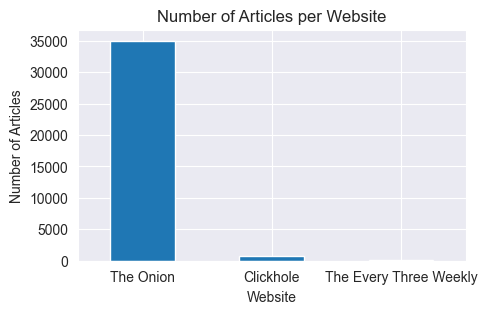

In [82]:
data.website.value_counts()\
    .plot(kind="bar", rot=0, figsize=(5, 3))

plt.title("Number of Articles per Website")
plt.ylabel("Number of Articles")
plt.xlabel("Website")
plt.show()

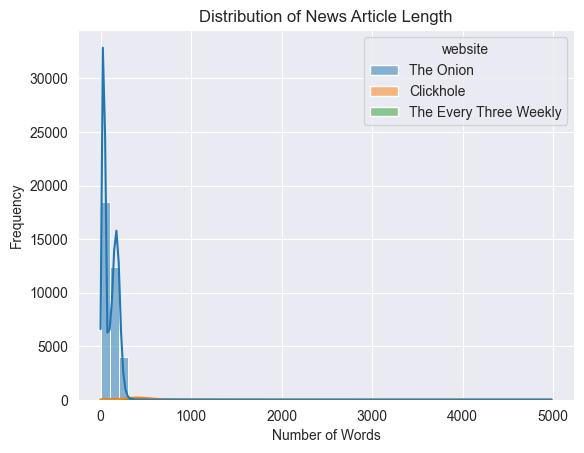

In [84]:
article_length = data['body'].str.split().apply(len)
data_copy = data.copy()
data_copy['article_length'] = article_length

sns.histplot(data_copy, x="article_length", hue="website", bins=50, kde=True)
plt.title('Distribution of News Article Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [85]:
article_length.describe()

count    35907.000000
mean       112.247500
std        107.431825
min          0.000000
25%         36.000000
50%         91.000000
75%        174.000000
max       4981.000000
Name: body, dtype: float64

In [86]:
article_length.quantile(0.99)

455.0